# Data Dive Week 10: Fitting and Evaluating Classification Models

Today we'll be looking at a real world application of logistic regression using data from loans requests posted on [Kiva.org](https://www.kiva.org/). 

![alt text](https://www-kiva-org.global.ssl.fastly.net/cms/sites/default/files/kivablog/preview_logo_1.jpg)

Kiva is an international nonprofit, founded in 2005 and based in San Francisco, with a mission to connect people through lending to alleviate poverty. Kiva seeks to celebrate and support people looking to create a better future for themselves, their families and their communities.

*By lending as little as $25 on Kiva, anyone can help a borrower start or grow a business, go to school, access clean energy or realize their potential. For some, it’s a matter of survival, for others it’s the fuel for a life-long ambition.*

## Today's Modeling Objective
Our focus today will be determining whether microfinance projects on [Kiva's site](https://www.kiva.org/) receive funding or not using a host of features made available by Kiva, along with some features we'll design ourselves. 

Today's data is a subsample of projects in Kenya, one of Kiva's most active countries for lending. We'll be working with 18,000 observation, 3,000 or which were funded. Documentation on the data is available on [Kiva's website](http://build.kiva.org/docs/data/basic_types).


In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold, train_test_split

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 40)
random_state = 20191028

In [ ]:
df = pd.read_csv('https://grantmlong.com/data/kiva_kenya_sample.csv')
print(df.shape)
print(list(df))
df.head()

(18000, 25)
['LOAN_ID', 'DESCRIPTION', 'FUNDED_AMOUNT', 'LOAN_AMOUNT', 'STATUS', 'ACTIVITY_NAME', 'SECTOR_NAME', 'LOAN_USE', 'TOWN_NAME', 'CURRENCY', 'PARTNER_ID', 'POSTED_TIME', 'PLANNED_EXPIRATION_TIME', 'DISBURSE_TIME', 'RAISED_TIME', 'LENDER_TERM', 'NUM_LENDERS_TOTAL', 'NUM_JOURNAL_ENTRIES', 'NUM_BULK_ENTRIES', 'TAGS', 'BORROWER_NAMES', 'BORROWER_GENDERS', 'BORROWER_PICTURED', 'REPAYMENT_INTERVAL', 'DISTRIBUTION_MODEL']


,LOAN_ID,DESCRIPTION,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,ACTIVITY_NAME,SECTOR_NAME,LOAN_USE,TOWN_NAME,CURRENCY,PARTNER_ID,POSTED_TIME,PLANNED_EXPIRATION_TIME,DISBURSE_TIME,RAISED_TIME,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL
0,854452,"Janepher, pictured above, is a group leader an...",725.0,1000.0,expired,Agriculture,Agriculture,to buy cost-efficient maize seeds and fertiliz...,Webuye,KES,202.0,2015-03-12 12:14:55.000 +0000,2015-04-17 06:40:03.000 +0000,2015-02-28 08:00:00.000 +0000,NaN,11.0,15,1,1,"#Eco-friendly, #Sustainable Ag, #Technology, #...","Teresa, Janepher, Joseph, Jane, Phylis J, Mild...","female, female, male, female, female, female, ...","true, true, true, true, true, true, true, true...",bullet,field_partner
1,868233,John is a married man. He has two children. He...,825.0,1100.0,expired,Grocery Store,Food,buy more stock of maize to produce maize flou...,Nakuru,KES,138.0,2015-04-10 10:47:35.000 +0000,2015-05-16 17:30:02.000 +0000,2015-04-07 07:00:00.000 +0000,NaN,14.0,14,1,1,"#Parent, #Repeat Borrower, #Vegan",JOHN,male,true,monthly,field_partner
2,1429009,Margaret is a single mother and lives with her...,275.0,500.0,expired,Farming,Agriculture,to buy hybrid seeds and fertilizers to use on ...,Siongiroi,KES,156.0,2017-12-06 10:12:14.000 +0000,2018-01-08 12:50:04.000 +0000,2017-11-27 08:00:00.000 +0000,NaN,20.0,11,1,1,"#Eco-friendly, #Woman Owned Biz",Margaret,female,true,monthly,field_partner
3,1077128,Agriphine is a proud mother of angelic-looking...,225.0,1000.0,expired,Farming,Agriculture,to buy farm supplies and seeds in order to exp...,Chuka,KES,156.0,2016-05-27 13:05:40.000 +0000,2016-07-03 03:30:03.000 +0000,2016-05-20 07:00:00.000 +0000,NaN,20.0,7,1,1,"#Parent, #Woman Owned Biz",Agriphine,female,true,monthly,field_partner
4,825980,Bernard is 32 years. He is married to Caroline...,275.0,500.0,expired,Butcher Shop,Food,to add stocks of pork meat.,Kisumu,KES,133.0,2015-01-09 09:10:57.000 +0000,2015-02-09 16:10:03.000 +0000,2014-12-11 08:00:00.000 +0000,NaN,14.0,8,1,1,"user_favorite, #Parent, #Repeat Borrower",BERNARD,male,true,monthly,field_partner


# Familiarizing Ourselves with the Data

### To get a sense of the different data points and examples here:
 1. Print **three** randomly selected project descriptions.
 2. Print **five** randomly selected examples of `POSTED_TIME`.
 3. Print the unique values and counts for `ACTIVITY_NAME`.
 4. Print the unique values and counts for `SECTOR_NAME`.
 5. Summarize the values for loan amount.
 6. Create a histogram for `NUM_LENDERS_TOTAL`. 

In [ ]:
# Print three randomly selected project descriptions.


In [ ]:
# Print five randomly selected examples of POSTED_TIME.


In [ ]:
# Print the unique values and counts for ACTIVITY_NAME.


In [ ]:
# Print the unique values and counts for SECTOR_NAME.


In [ ]:
# Summarize the values for loan amount.


In [ ]:
# Create a histogram for NUM_LENDERS_TOTAL


# Tidying Up Our Data

Now that we've taken a closer look at our data, there are a few things we'll want to do to prep our data for modeling: 
 1. Create a target variable
 2. Generate a more usable version of the `POSTED_TIME` column.
 3. Generate a variable with the amount of planned time before expiration for each project. 
 4. Generate boolean variables for each of the following categorical columns:
   * `SECTOR_NAME`
   * `ACTIVITY_NAME`
   * `REPAYMENT_INTERVAL`
 5. Create boolean variables for a handful of other free text and categorical columns, including:
   * `BORROWER_PICTURED`
   * `BORROWER_GENDERS`
   * `DISTRIBUTION_MODEL`
 
 

##### Let's choose and create a variable for our target. 
Remember, we're trying to determine whether microfinance projects on Kiva's site receive funding or not. 

##### Let's make features for both `posted_year` and `posted_duration` 

In [ ]:
df['posted_year'] = pd.to_datetime(df.POSTED_TIME).dt.year
df['posted_duration'] = (pd.to_datetime(df.PLANNED_EXPIRATION_TIME)
                             - pd.to_datetime(df.POSTED_TIME)
                            ).dt.days
                            

##### Let's create binary (1/0) features for `SECTOR_NAME`, `ACTIVITY_NAME`, and `REPAYMENT_INTERVAL`


In [ ]:
sector_names = ['sector_' + name.lower() for name in df.SECTOR_NAME.unique()]
for name in df.SECTOR_NAME.unique():
    df['sector_' + name.lower()] = (df.SECTOR_NAME==name)*1

activity_names = ['activity_' + name.lower() for name in df.ACTIVITY_NAME.value_counts().head(10).index.values]
for name in df.ACTIVITY_NAME.unique():
    df['activity_' + name.lower()] = (df.ACTIVITY_NAME==name)*1

repayment_types = ['repayment_' + interval.lower() for interval in df.REPAYMENT_INTERVAL.unique()]
for interval in df.REPAYMENT_INTERVAL.unique():
    df['repayment_' + interval.lower()] = (df.REPAYMENT_INTERVAL==interval)*1


##### Let's create binary (1/0) features for `has_borrower_pic`, `has_female_borrower`, `direct_distribution`, and `currency_usd`


In [ ]:
other_names = ['has_borrower_pic', 'has_female_borrower', 'direct_distribution', 'currency_usd']

df['has_borrower_pic'] = df.BORROWER_PICTURED.str.contains('true')*1
df['has_borrower_pic'] = df['has_borrower_pic'].fillna(0)

df['has_female_borrower'] = df.BORROWER_GENDERS.str.contains('female')*1
df['has_female_borrower'] = df['has_female_borrower'].fillna(0)

df['direct_distribution'] = (df.DISTRIBUTION_MODEL=='direct')*1

df['currency_usd'] = (df.CURRENCY=='USD')*1


# Data Handling

#### To get our data into formats that work well with `sci-kit learn`, we'll need to: 
 1. Identify our features and isolate them in a new dataframe.
 2. Split our dataset into train and holdout splits. 
 


In [ ]:
features = (['posted_year', 'posted_duration', 'LOAN_AMOUNT', 'LENDER_TERM', 'NUM_JOURNAL_ENTRIES'] 
            + repayment_types + sector_names + activity_names 
            + other_names
           )

model_df = df[(features + ['success'])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df['success'], test_size=0.1,
    random_state=random_state)

train_df['success'] = y_train
holdout_df['success'] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

print(train_df.shape[0], train_df.success.mean())
print(holdout_df.shape[0], holdout_df.success.mean())

14297 0.6211792683779814
1589 0.632473253618628


In [ ]:
print(features)

['posted_year', 'posted_duration', 'LOAN_AMOUNT', 'LENDER_TERM', 'NUM_JOURNAL_ENTRIES', 'repayment_bullet', 'repayment_monthly', 'repayment_irregular', 'repayment_weekly', 'sector_agriculture', 'sector_food', 'sector_retail', 'sector_transportation', 'sector_clothing', 'sector_housing', 'sector_construction', 'sector_services', 'sector_education', 'sector_personal use', 'sector_arts', 'sector_health', 'sector_manufacturing', 'sector_wholesale', 'sector_entertainment', 'activity_farming', 'activity_general store', 'activity_dairy', 'activity_retail', 'activity_agriculture', 'activity_cereals', 'activity_clothing sales', 'activity_motorcycle transport', 'activity_fruits & vegetables', 'activity_grocery store', 'has_borrower_pic', 'has_female_borrower', 'direct_distribution', 'currency_usd']


In [ ]:
model_df.shape

(15886, 40)

In [ ]:
train_df.shape

(14297, 40)

In [ ]:
holdout_df.shape

(1589, 40)

# Model Training

Let's take a quick look at all of our classification model options using cross validation. For the tree based models, we'll use the hyperparameter `max_depth=5` as a naive attempt at avoiding overfitting before we dig deeper.

##### Let's fit and score the model, this time using cross validation:

In [ ]:
k_fold = KFold(n_splits=5, random_state=random_state)

In [ ]:
def get_cv_results(classifier):
    
    results = []
    for train, test in k_fold.split(train_df):
        classifier.fit(train_df.loc[train, features], train_df.loc[train, 'success'])
        y_predicted = classifier.predict(train_df.loc[test, features])
        accuracy = accuracy_score(train_df.loc[test, 'success'], y_predicted)
        results.append(accuracy)
        #print(accuracy)
    return np.mean(results), np.std(results)


#### First, let's look at the cv performance of Logistic Regression

In [ ]:
logreg = LogisticRegression(
    random_state=random_state, 
    solver='lbfgs'
)

get_cv_results(logreg)

(0.7610689345631634, 0.006797944041968363)

#### Next, let's take a naive attempt to beat Logistic Regression using a Tree

In [ ]:
dtree = DecisionTreeClassifier(
    random_state=random_state, 
    max_depth=5
)

get_cv_results(dtree)

(0.8164649481333637, 0.0037257381470358945)

#### Looks like a non-linear method gives us a big boost. Let's try a Random Forest.

In [ ]:
rforest = RandomForestClassifier(
    #random_state=random_state, 
    max_depth=5,
    n_estimators=100
)

get_cv_results(rforest)

(0.8302440092261708, 0.00641818441138857)

#### Finally, let's take a naive approach to Gradient Boosting.

In [ ]:
gbm = GradientBoostingClassifier(
    random_state=random_state, 
    max_depth=5,
    n_estimators=100
)

get_cv_results(gbm)

(0.8592711765324565, 0.0016786691276004554)

### Learning Curves, Revisited

Now that we're working with a more complex data set, we should be able to build more robust learning curves than we had experience with when we were using the  

In [ ]:
hp_values = range(1,50, 2)
all_mu = []
all_sigma = []

for m in hp_values:

    dtree=DecisionTreeClassifier(
        criterion='entropy', 
        random_state=random_state, 
        max_depth=m,
    )

    mu, sigma = get_cv_results(dtree)
    all_mu.append(mu)
    all_sigma.append(sigma)
    
    print(m, mu, sigma)

1 0.7030132546711771 0.011098985250362634
3 0.7760367334659044 0.011554924472987402
5 0.8152057910609851 0.004185597138869119
7 0.8233196604025566 0.006386478214900568
9 0.8324826520104589 0.005987091328162801
11 0.8377976553002785 0.00532458045036516
13 0.8423447486406562 0.00479623948810901
15 0.840176671876567 0.005202260264646533
17 0.8391273050139787 0.006354178729814936
19 0.8383578541081164 0.007255513045257531
21 0.8342312951127221 0.007739073810672704
23 0.8348605923632156 0.007929322226066527
25 0.8333917918388012 0.008431458271949323
27 0.8294749985935714 0.007808546588040986
29 0.8283556282821761 0.005648424340123772
31 0.8284259007868661 0.006391415251452175
33 0.8280760792198357 0.006172007698022108
35 0.8272364781074121 0.00660548279609776
37 0.8267468208601473 0.006088493912561361
39 0.8270266389783704 0.0064351811494795675
41 0.8270965935079262 0.006389126356717897
43 0.8267468208601473 0.006088493912561361
45 0.826816775389703 0.006143427011023478
47 0.826816775389703

Text(0.5, 0, 'Max Depth')

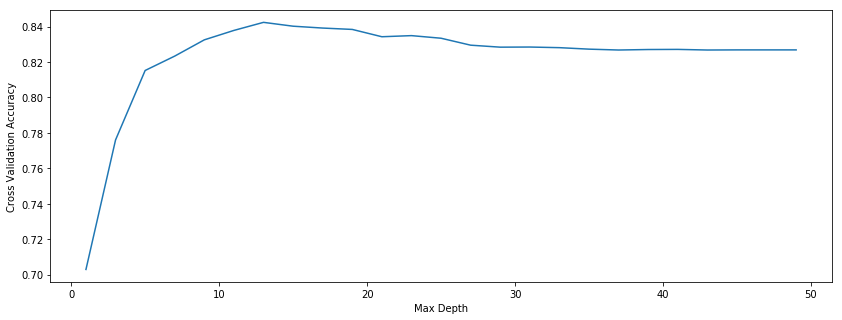

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_mu)
plt.ylabel('Cross Validation Accuracy')
plt.xlabel('Max Depth')

Text(0.5, 0, 'Max Depth')

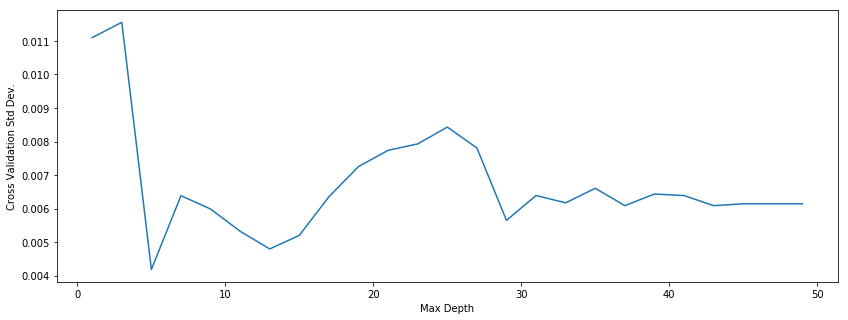

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_sigma)
plt.ylabel('Cross Validation Std Dev.')
plt.xlabel('Max Depth')

# Evaluating Model Performance

We can use ROC curves to look at how our models perform across a variety of threshholds against our holdout data. 


In [ ]:
def plot_roc(classifier, label, color):

    classifier.fit(train_df[features], train_df['success'])
    y_prob = classifier.predict_proba(holdout_df[features])
    
    fpr, tpr, thresh = roc_curve(holdout_df['success'], y_prob[:,1])
    plt.plot(fpr, tpr,
             label=label,
             color=color, linewidth=3)

    auc = roc_auc_score(holdout_df['success'], y_prob[:,1])
    
    print('AUC: %0.3f (%s)' % (auc, label))
 

AUC: 0.866 (Logistic Regression)
AUC: 0.912 (Decision Tree)
AUC: 0.931 (Random Forest)
AUC: 0.938 (GBM)


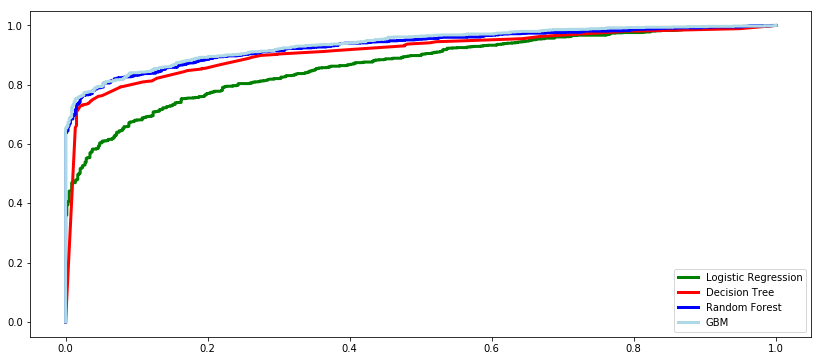

In [ ]:
f1 = plt.figure(figsize=(14,6))

logreg = LogisticRegression(
    random_state=random_state, 
    solver='lbfgs'
)
plot_roc(logreg, 'Logistic Regression', 'green')

dtree = DecisionTreeClassifier(
    random_state=random_state, 
    max_depth=10
)
plot_roc(dtree, 'Decision Tree', 'red')

rforest = RandomForestClassifier(
    random_state=random_state, 
    max_depth=10,
    n_estimators=100
)
plot_roc(rforest, 'Random Forest', 'blue')

gbm = GradientBoostingClassifier(
    random_state=random_state, 
    max_depth=10,
    n_estimators=100
)
plot_roc(gbm, 'GBM', 'lightblue')

plt.legend(loc='lower right')

## Review and Discussion: 
 * Why do we think GBMs exhibit the best performance here? 
 * In what situations might they not work as well?